# Time Series Analysis for Climate Change Using Earth Surface Temperature Data

## 1. Project Background

Our planet's getting warmer, that's no secret. But how much warmer, and how fast is it happening? That's where understanding the history of Earth's temperature comes in. This project dives into temperature data from the ground up, using powerful tools to uncover the hidden patterns and trends that tell the story of climate change. By looking back, we can make smarter decisions about the future.

## 2. What is a time series?

A time series is a sequence of data points collected at successive time intervals. It represents how a variable changes over time. For instance, when examining Earth's surface temperature, monthly measurements gathered over decades and visualised in a graph provide a clear illustration of a time series. This approach allows for detailed analysis and pattern recognition in understanding temperature trends and variations over extended periods. This approach helps us see a pattern and understand temperature trends and variations over extended periods. 


## 3. What is ARIMA Model?

The ARIMA (AutoRegressive Integrated Moving Average) model is a form of regression analysis that checks the strength of one dependent variable relative to changing values. It consists of three main components:

**AutoRegressive (AR)**: Examines how past values of a variable affect its current value by modelling the connection between an observation and its prior values to forecast the present value.

**Integrated (I)**: Involves differencing raw observations (e.g., subtracting an observation from the previous time step) to ensure the time series becomes stationary.

**Moving Average (MA)**: Uses the relationship between an observation and the error from a previous forecast to predict future values.

Parameters in ARIMA are denoted as (p, d, q):

**p (AutoRegressive Order)**: captures how many past observations directly influence the current prediction.

**d (Differencing Order)**: umber of times the data is differenced to achieve stationarity, removing trends and seasonality.

**q (Moving Average Order)**: size of the moving average window, accounting for the influence of past forecast errors.

Applying the ARIMA model to Earth surface temperature data enables us to uncover underlying trends and seasonal patterns and make informed predictions for the future. This approach enhances our understanding of climate change dynamics through statistical analysis.



## 4. Data

Link to dataset: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByState.csv

## Importing the libraries

In [252]:
import pandas as pd
from datetime import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import warnings

## Importing the dataset

In [253]:
# Load the dataset 
df = pd.read_csv('archive/GlobalLandTemperaturesByState.csv', header=0)
# Print the first few rows and data types
print(df.head())
print(df.dtypes)

           dt  AverageTemperature  AverageTemperatureUncertainty State Country
0  1855-05-01              25.544                          1.171  Acre  Brazil
1  1855-06-01              24.228                          1.103  Acre  Brazil
2  1855-07-01              24.371                          1.044  Acre  Brazil
3  1855-08-01              25.427                          1.073  Acre  Brazil
4  1855-09-01              25.675                          1.014  Acre  Brazil
dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
State                             object
Country                           object
dtype: object


### Exploring the dataset

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [255]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,620027.000000,620027.000000
mean,8.993111,1.287647
std,13.772150,1.360392
min,-45.389000,0.036000
25%,-0.693000,0.316000
50%,11.199000,0.656000
75%,19.899000,1.850000
max,36.339000,12.646000


In [256]:
# Checking unique countries 
unique_countries = df['Country'].unique()
num_unique_countries = len(unique_countries)
print(f'Number of unique countries: {num_unique_countries}')

Number of unique countries: 7


In [257]:
# checking unique cities
unique_states = df['State'].unique()
num_unique_states = len(unique_states)

print(f'Number of unique cities: {num_unique_states}')

Number of unique cities: 241


In [258]:
initial_start_date = df['dt'].min()
initial_end_date = df['dt'].max()
print("Initial Date Range: ", initial_start_date, " to ", initial_end_date)


Initial Date Range:  1743-11-01  to  2013-09-01


## Data Preprocessing

### Taking care of missing data

In [259]:
print(df.isnull().sum())

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64


In [260]:
# Interpolating missing values
df['AverageTemperature'] = df['AverageTemperature'].interpolate(method='linear').ffill().bfill()
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].interpolate(method='linear').ffill().bfill()
print(df.isnull().sum())

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64


While removing missing temperature data creates gaps, interpolation fills them using surrounding values for smoother trend analysis.

### Taking care of duplicate rows

In [261]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Print the result
if duplicate_rows.empty:
    print("No duplicate rows found.")
else:
    print("Duplicate rows found.")

No duplicate rows found.


### Data Renaming

In [262]:
df.rename(columns={'dt' : 'Date','AverageTemperature': 'Avg_temp', 'AverageTemperatureUncertainty': 'CI_temp'},inplace=True)
df.head()

,Date,Avg_temp,CI_temp,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


### Handling Data Types

In [263]:
#Converting 'Date column' into 'Datetime datatype'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace = True)
df.index

DatetimeIndex(['1855-05-01', '1855-06-01', '1855-07-01', '1855-08-01',
               '1855-09-01', '1855-10-01', '1855-11-01', '1855-12-01',
               '1856-01-01', '1856-02-01',
               ...
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='Date', length=645675, freq=None)

To effectively utilise the ARIMA model, several transformations are necessary. First, the data must be converted to a Pandas series, and then the date and time should be set as the index. The timestamps need to be in an immutable tuple format because iterating through tuple elements is faster than through a list. This process results in a series object with immutable timestamps.

### Final Dataset

In [264]:
#Now we use year as index
df['year']= df.index.year
df['month'] = df.index.month
df.head()

,Avg_temp,CI_temp,State,Country,year,month
Date,,,,,,
1855-05-01,25.544,1.171,Acre,Brazil,1855,5
1855-06-01,24.228,1.103,Acre,Brazil,1855,6
1855-07-01,24.371,1.044,Acre,Brazil,1855,7
1855-08-01,25.427,1.073,Acre,Brazil,1855,8
1855-09-01,25.675,1.014,Acre,Brazil,1855,9


By separating the data into specific months or years allows for further data exploration, seasonality comprehension, and data interpretability, which ultimately improves ARIMA model interpretability.

## Exploratory Data Analysis

In [265]:
#Grouping available data based on average temperature
df[['Country','Avg_temp']].groupby(['Country']).mean().sort_values('Avg_temp')

,Avg_temp
Country,
Canada,-0.850658
Russia,1.705690
United States,10.670634
China,11.076285
Australia,17.748491
India,22.093047
Brazil,23.862177


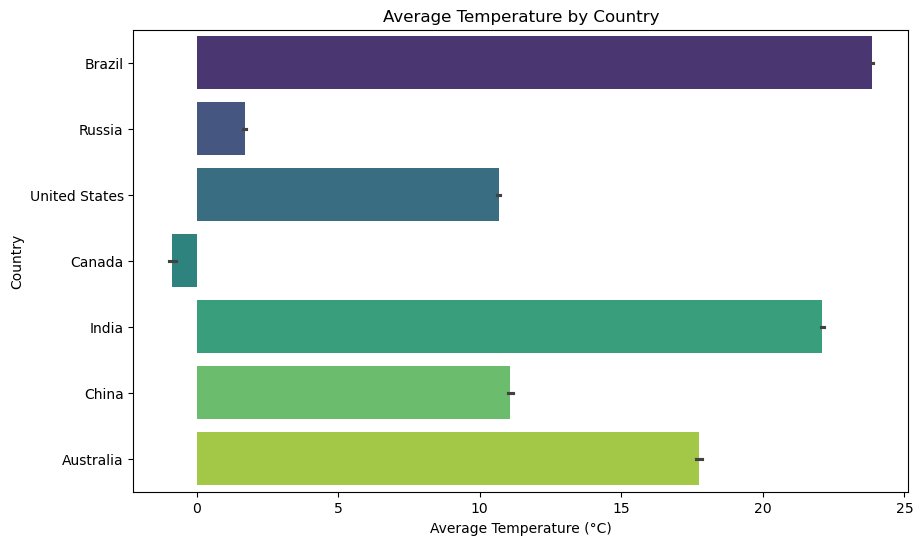

In [266]:
# Plotting the average temerature by contry
plt.figure(figsize=(10, 6))
sns.barplot(x='Avg_temp', y='Country', data=df, palette='viridis', hue='Country', dodge=False, legend=False)
plt.title('Average Temperature by Country')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Country')
plt.show()

Observing the graph, it shows that Brasil has the highest average temperature and Canada has the lowest among the countries displayed.

## Visualising the Surface Temperature by year

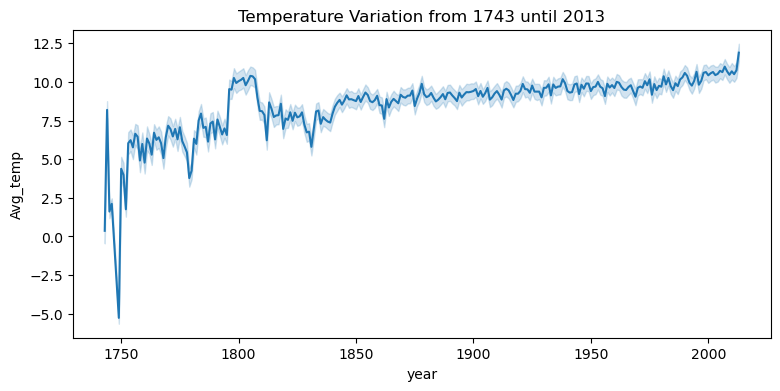

In [267]:
#Plotting graph between year and average temperature
# Each point on the line represents the average temperature for a specific year.
plt.figure(figsize=(9,4))
sns.lineplot(x = "year" , y = "Avg_temp",data=df)
plt.title('Temperature Variation from 1743 until 2013')
plt.show()

The initial temperature spike in the dataset may be due to factors like recording methods or extreme events. The graph shows an increase in temperature over time. There was a peak in 1800, and it was possibly caused by human activity since the industrial revolution started about 1760. The constant rise in temperature, especially after the industrial revolution, highlights the importance of cutting emissions and taking action to reduce the effects of global warming.


##  Visualising the Surface Temperature by Month

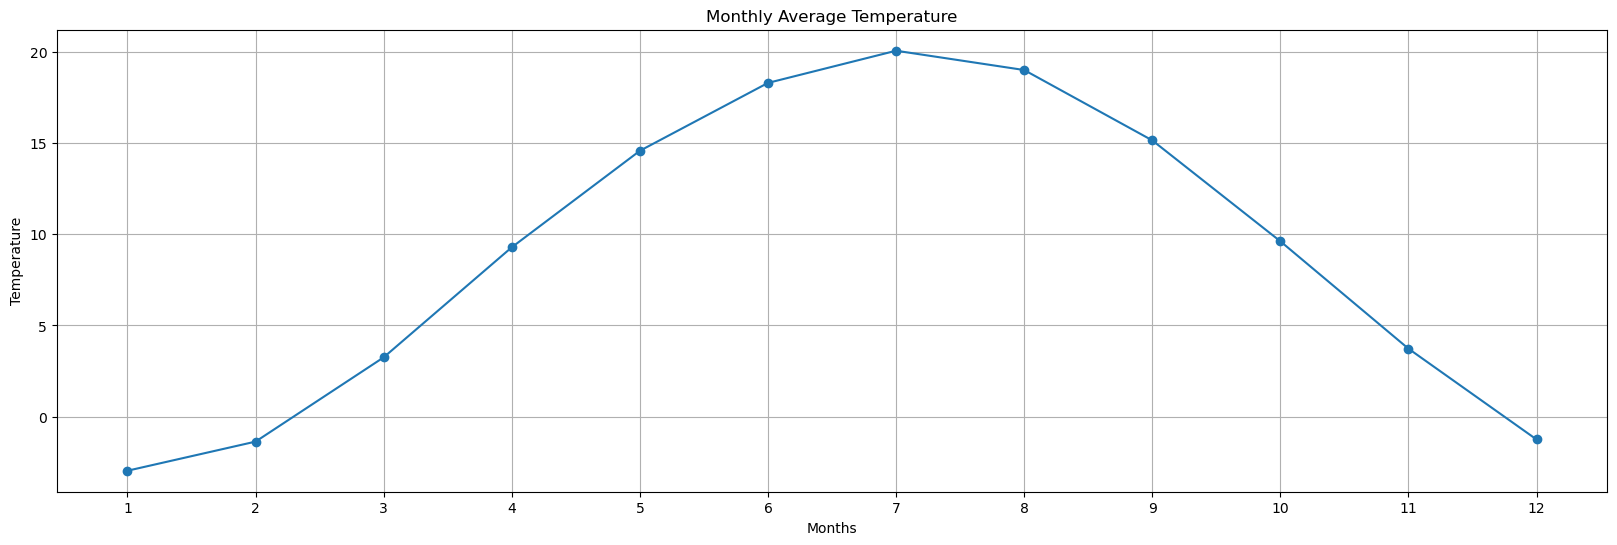

In [268]:
# Pivot all months into just one line and taking the average temeprature per month
pivot = df.pivot_table(index='month', values='Avg_temp', aggfunc='mean')

plt.figure(figsize=(20, 6))
plt.plot(pivot.index, pivot['Avg_temp'], marker='o', linestyle='-')
plt.title('Monthly Average Temperature')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.show()

From this graph, we can see that there is some seasonality; the higher temperatures are around May and September and the lower are between November and March. 

In [269]:
# Dropping unnecessary columns
resample_df = df[['Avg_temp']].resample('A').mean()
resample_df.head()

,Avg_temp
Date,
1743-12-31,0.365624
1744-12-31,8.191005
1745-12-31,1.612856
1746-12-31,2.112950
1747-12-31,-0.347319


For the ARIMA model to work, data must be stored in Panda's series, date and time moved to the index, and time stamps in an immutable tuple format, as iterating through tuples is faster. Also, unnecessary columns have been removed.

In [313]:
average_temp_current_dataset = resample_df['Avg_temp'].mean()
print("Average Temperature for the Current Dataset:", average_temp_current_dataset)


Average Temperature for the Current Dataset: 8.488551682307934


### Visualising Annual Average Temeprature 

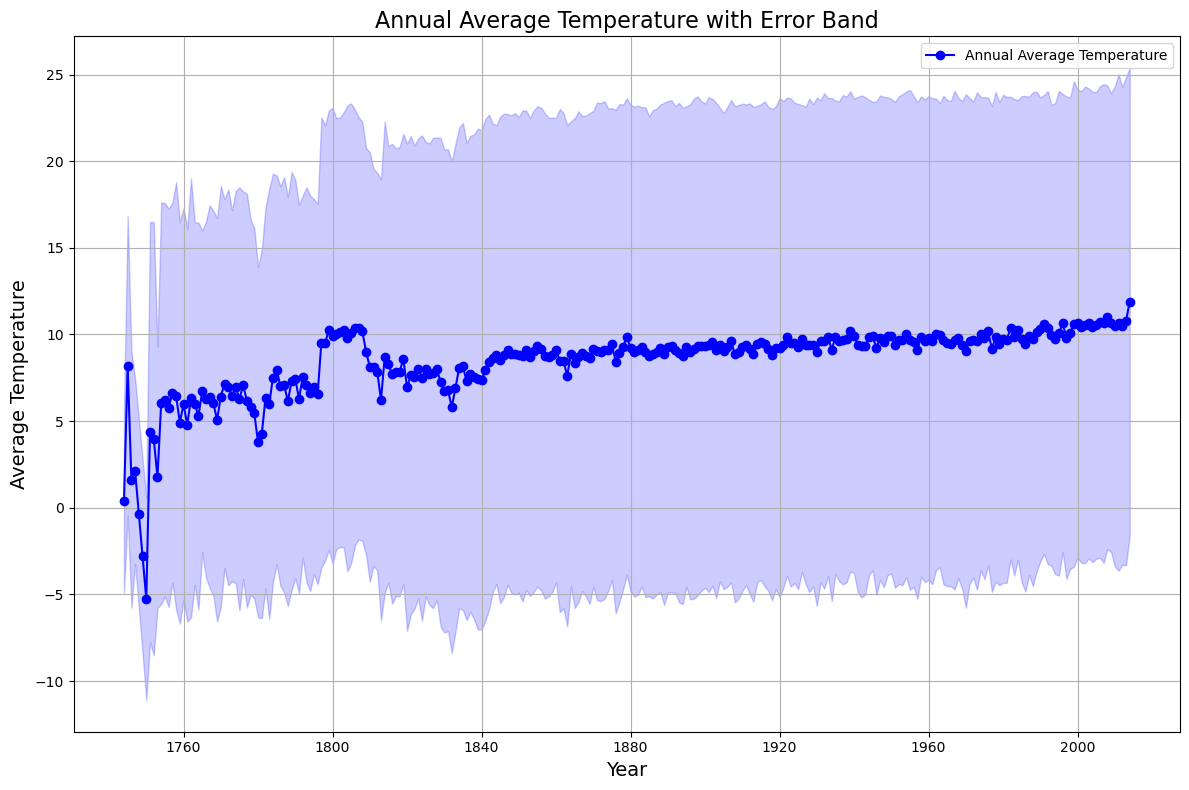

In [270]:
# Calculate standard deviation for error band
std_dev = df[['Avg_temp']].resample('A').std()

# Plotting line plot with shaded error band
plt.figure(figsize=(12, 8))
plt.plot(resample_df.index, resample_df['Avg_temp'], marker='o', color='b', label='Annual Average Temperature')
plt.fill_between(resample_df.index, (resample_df['Avg_temp'] - std_dev['Avg_temp']), (resample_df['Avg_temp'] + std_dev['Avg_temp']), color='b', alpha=0.2)
plt.title('Annual Average Temperature with Error Band', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Temperature', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows the trend of average temperature over time. The blue line indicates the annual average temperature, while the shaded represents the uncertainty in these measurements.

## Visualising Rolling Mean & Standard Deviation 


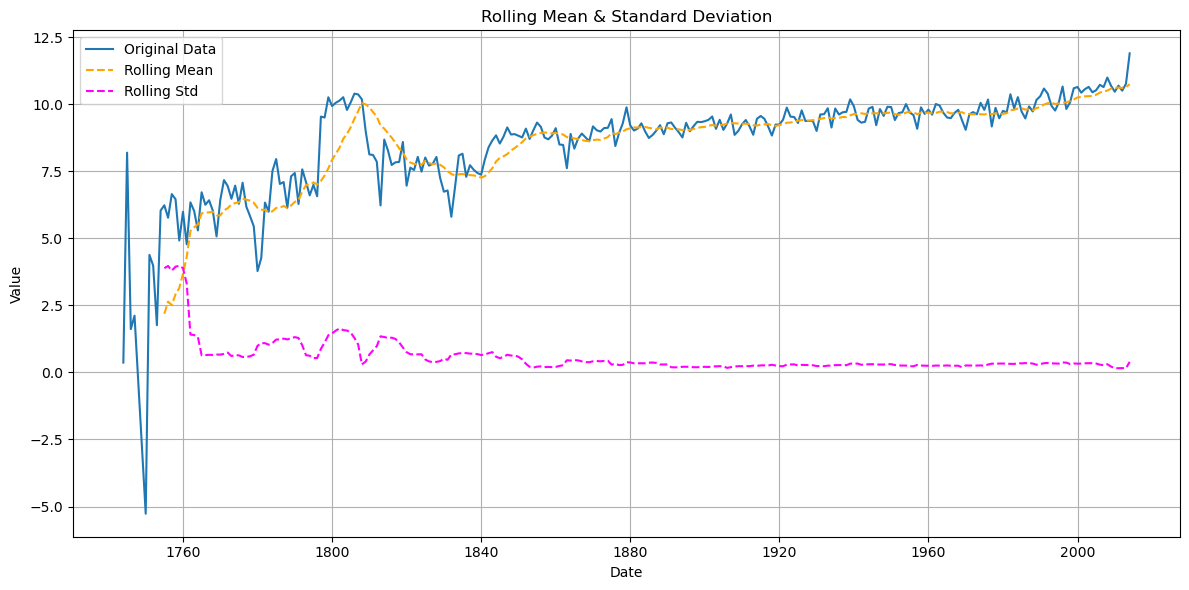

In [271]:
# Calculate rolling statistics
window_size = 12
rolling_mean = resample_df.rolling(window=window_size, center=False).mean()
rolling_std = resample_df.rolling(window=window_size, center=False).std()
plt.figure(figsize=(12, 6))
plt.plot(resample_df, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean', linestyle='--', color='orange')
plt.plot(rolling_std, label='Rolling Std', linestyle='--', color='magenta')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows yearly temperature trends and their variability. The smooth line is a rolling average (often 3 years) highlighting the average temperature trend. The low rolling standard deviation compared to the mean indicates minimal year-to-year temperature fluctuations.



##  Visualising Temperature Changes

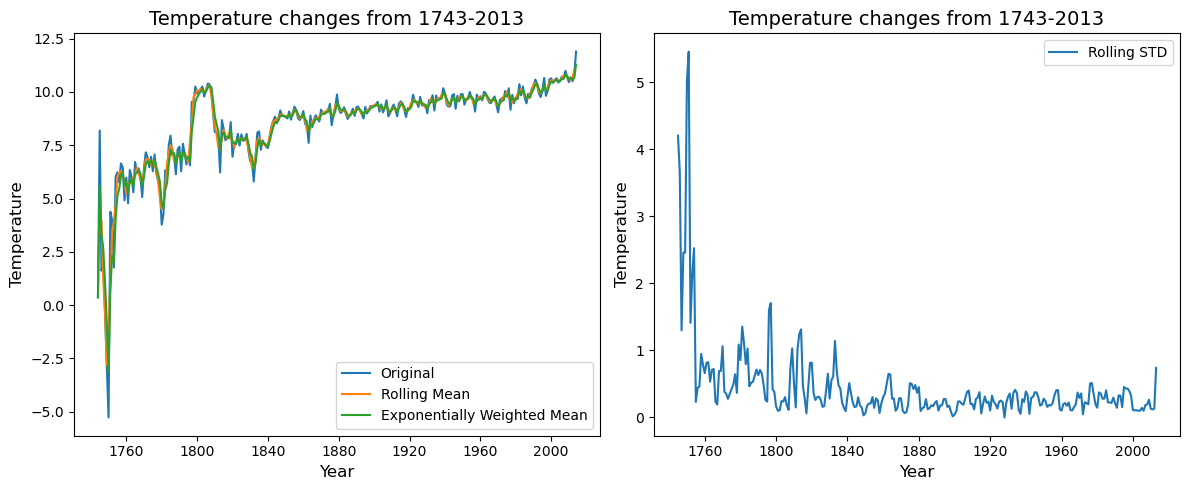

In [272]:
# Calculate the rolling mean with a window size of 3 and centering the window
rol_mean = resample_df.rolling(window=3,center=True).mean()
ewm = resample_df.ewm(span=3).mean()
rol_std = resample_df.rolling(window=3,center=True).std()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(resample_df,label='Original')
ax1.plot(rol_mean,label='Rolling Mean')
ax1.plot(ewm, label='Exponentially Weighted Mean')
ax1.set_title('Temperature changes from 1743-2013',fontsize=14)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

ax2.plot(rol_std,label='Rolling STD')
ax2.set_title('Temperature changes from 1743-2013',fontsize=14)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

To show long-term changes, annual temperatures were plotted using smoothed trends (rolling mean). While the smoothing (EWM) highlights recent trends, the rolling mean (3-year window) smooths out year-to-year variations. Rolling standard deviation is displayed separately and shows a sharp peak at earlier dates that gradually decreases over time, suggesting that the dispersion of the temperature data around the mean is decreasing over time, possibly due to increased predictability or improved recording accuracy. Further investigation is required.



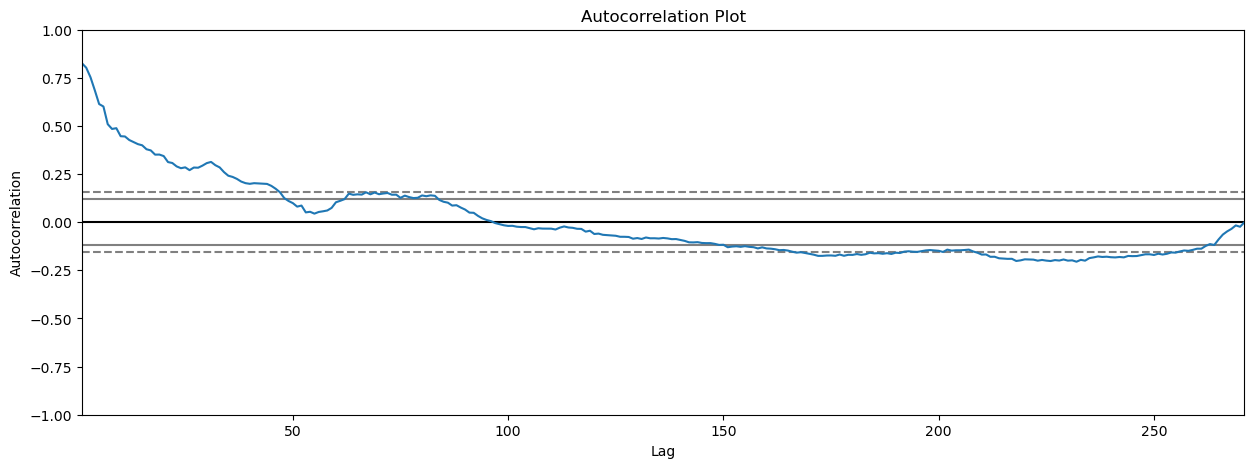

In [273]:
# Plotting autocorrelation
plt.figure(figsize=(15, 5))
autocorrelation_plot(resample_df)
plt.title('Autocorrelation Plot')
plt.grid()
plt.show()

This plot shows how annual temperatures correlate with themselves at different time lags. Since most of your line falls within this area, there's no clear pattern of temperatures being consistently higher or lower compared to temperatures at previous points in time.

## Decomposed Plots

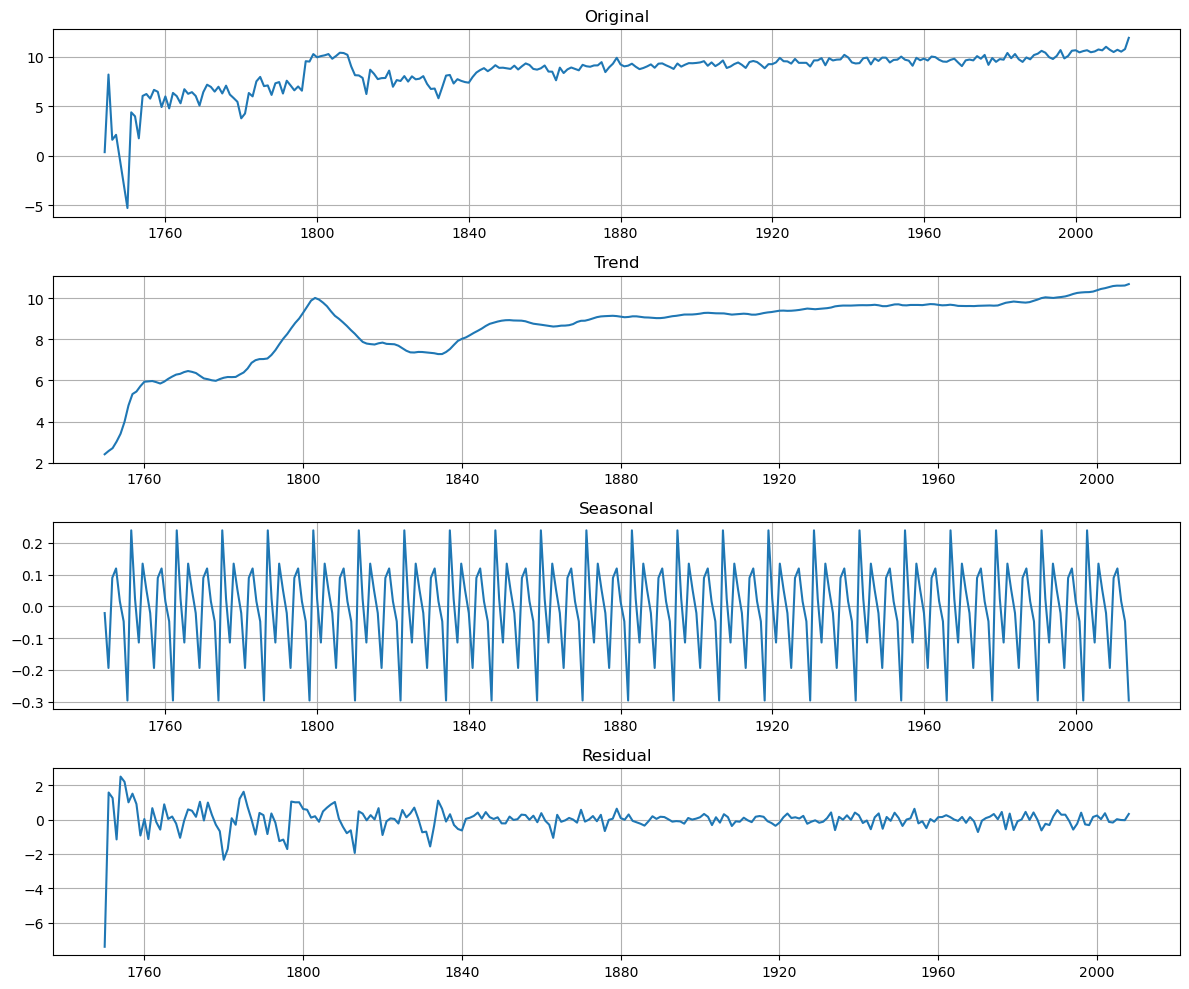

In [274]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


# Perform seasonal decomposition
decomp = seasonal_decompose(resample_df, period=12)  

# Extract decomposed components
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plotting the decomposed components
plt.figure(figsize=(12, 10))

# Original data
plt.subplot(411)
plt.plot(resample_df)
plt.title('Original')
plt.xlabel('')
plt.grid(True)

# Trend component
plt.subplot(412)
plt.plot(trend)
plt.title('Trend')
plt.xlabel('')
plt.grid(True)

# Seasonal component
plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal')
plt.xlabel('')
plt.grid(True)

# Residual component
plt.subplot(414)
plt.plot(residual)
plt.title('Residual')
plt.xlabel('')
plt.grid(True)

plt.tight_layout()
plt.show()

This graph shows that the trend and seasonality from the series have some pattern; even the residual shows high variance in the early rather than the later years.

In [275]:
# Stationarity Test
def stationarity_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)
    if df_test[0] < df_test[4]['5%']:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

stationarity_test(resample_df['Avg_temp'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.902051
p-value                          0.045110
Number of Lags                  10.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64
The series is stationary.


The series must be stationary, which means that its mean and variance do not change over time, in order to be forecasted as a time series. The Fuller test was run to confirm stationarity. The test value in this dataset is less than 0.05, which verifies the stationarity of the data.

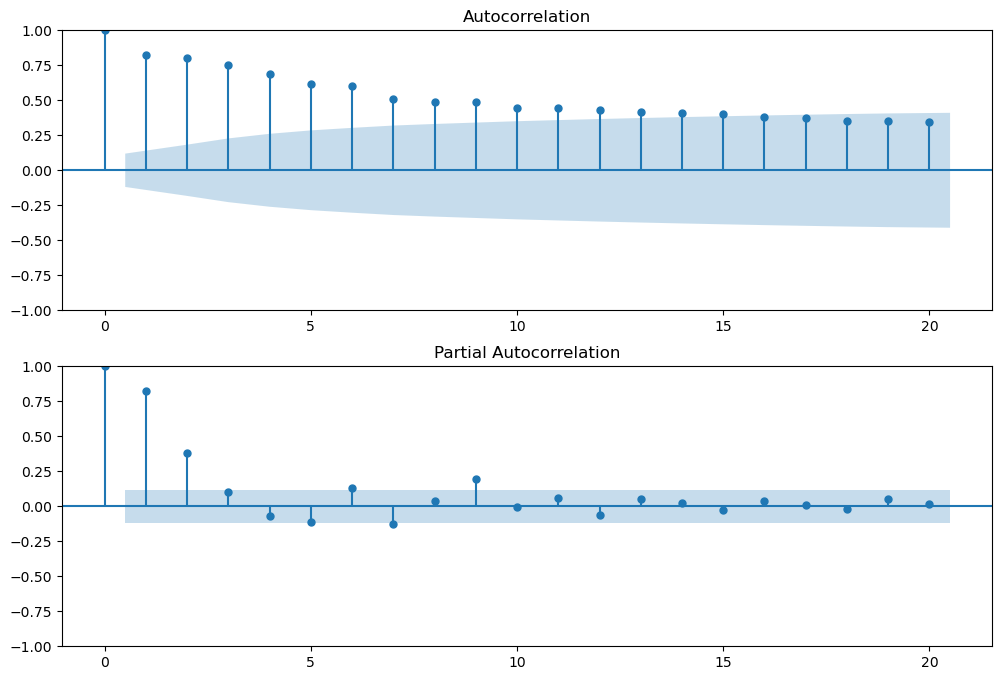

In [276]:
# Plot ACF and PACF
fig = plt.figure(figsize=(12, 8))

# Plot ACF
ax1 = fig.add_subplot(211)
plot_acf(resample_df, ax=ax1, lags=20)

# Plot PACF
ax2 = fig.add_subplot(212)
plot_pacf(resample_df, ax=ax2, lags=20)

plt.show()

Next, using ACF and PACF to specify the order of autoregression lags (p) and the moving average (q). The ACF plot shows the correlation between current temperatures and their lagged versions, while the PACF plot shows the correlation between current temperatures and their lagged versions, excluding the effects of earlier lags.

The autoregression for lag 1 has a big spike, meaning that the current temperature is directly related to the previous day's temperature. The PACF graph also shows a big spike on lag 1, which relates to yesterday's temperature.

The ARIMA 1,0,0 considers yesterday's temperature; ignoring any other past temperature, it is a good starting point. 


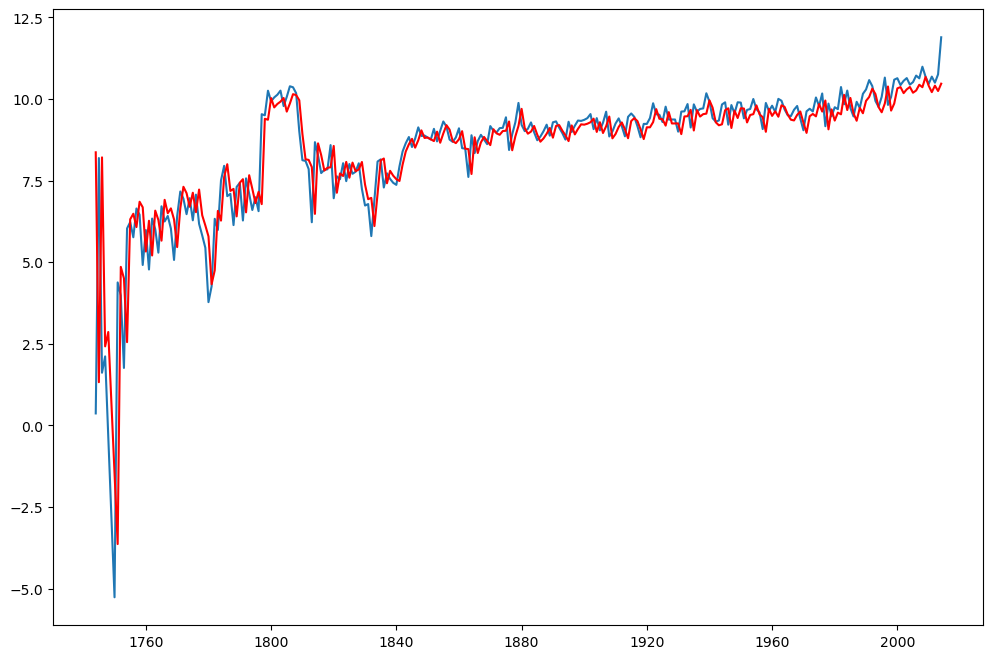

In [277]:
model = ARIMA(resample_df, order=(1,0,0))
results_AR1 = model.fit()
plt.figure(figsize=(12, 8))
plt.plot(resample_df)
plt.plot(results_AR1.fittedvalues, color='red')
plt.show()

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)


The ARIMA model was implemented using the function. The red line in the following graph represents the actual temperature values, while the blue line represents the model's predicted values. As clear from the graph, the predicted values closely resemble the actual data, suggesting a good model fit.

In [278]:
resample_df.tail()

,Avg_temp
Date,
2009-12-31,10.461537
2010-12-31,10.686661
2011-12-31,10.500732
2012-12-31,10.755588
2013-12-31,11.891855


The next step is to try to improve the current model by measuring the residuals.This prints the last 5 rows of the resample_df DataFrame, which contains the real average temperature for each year from 2009 to 2013.

In [279]:
results_AR1.fittedvalues.tail()

Date
2009-12-31    10.407914
2010-12-31    10.211019
2011-12-31    10.409219
2012-12-31    10.245526
2013-12-31    10.469902
Freq: A-DEC, dtype: float64

This prints the last 5 rows of the fitted values, showing the model's predicted temperatures for the same years.



In [280]:
results_AR1.resid.tail()

Date
2009-12-31    0.053624
2010-12-31    0.475642
2011-12-31    0.091513
2012-12-31    0.510062
2013-12-31    1.421953
Freq: A-DEC, dtype: float64

This prints the last 5 rows of the residuals, which are the differences between the observed and predicted temperatures for the same years. Loking at 2013-12-31 with value in 11.891855 (actual temperature) - 10.478896 (predicted temperature = 1.412959 (residual). Residuals represent the differences between the actual data points and the model's predictions.

In [281]:
# Use the residuals already calculated by the AR(2) model
residuals = results_AR1.resid
print("Residuals:")
print(residuals.tail())

Residuals:
Date
2009-12-31    0.053624
2010-12-31    0.475642
2011-12-31    0.091513
2012-12-31    0.510062
2013-12-31    1.421953
Freq: A-DEC, dtype: float64


Manually calculate residuals by subtracting the fitted values from the observed average temperatures.

In [282]:
# Calculate the mean of the residuals
mean_residuals = residuals.mean()
print("Mean of Residuals:", mean_residuals)

Mean of Residuals: 0.026000742158414622


The mean was also calculated; the closer to zero the mean, the smaller is the difference between the predicted and actual baseline values, the better the model.



In [283]:
results_AR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Avg_temp   No. Observations:                  271
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -405.988
Date:                Sun, 07 Jul 2024   AIC                            817.976
Time:                        10:54:55   BIC                            828.783
Sample:                    12-31-1743   HQIC                           822.315
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3669      0.796     10.516      0.000       6.807       9.926
ar.L1          0.8804      0.018     49.497      0.000       0.846       0.915
sigma2         1.1652      0.043     27.341      0.000       1.082       1.249
===================================================================================
Ljung-Box (L1) (Q):                  32.31   Jarque-Bera (JB):              5612.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The AIC and BIC are the key figures to look for. The model’s AIC and BIC are relatively low, suggesting a good fit. However, the non-normal distribution of residuals (high Jarque-Bera statistic) is very high, indicating the errors (residuals) are not normally distributed, meaning the model might not capture all temperature variations in the data, which could affect how precise the predictions are.

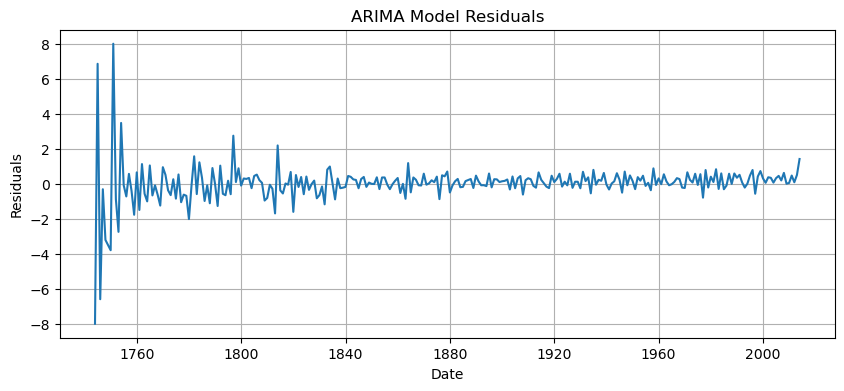

In [284]:
# Plot residuals
residuals = results_AR1.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

High variations at the beginning of the dataset could be due to the irregular methods of capturing the data. Also, low residuals towards the end of the model means it is performing well.

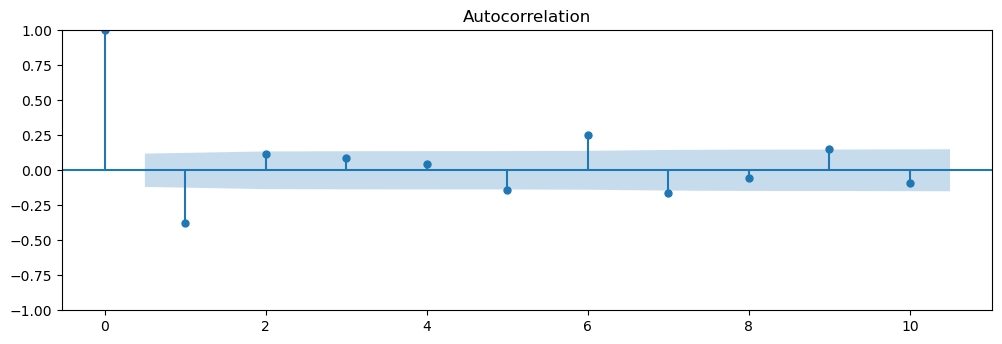

In [285]:
# ACF plot of residuals
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR1.resid, lags=10, ax=ax1)
plt.show()

In [286]:
# Histogram of residuals
def resid_histogram(data):
    from scipy.stats import norm
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', density=True, rwidth=0.85, label='Residuals')
    mean_resid, std_resid = norm.fit(data)
    curve_length = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
    plt.plot(curve_length, bell_curve, 'm', linewidth=2)
    plt.grid(axis='y', alpha=0.2)
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Residuals vs Normal Distribution - Mean')
    plt.show()                                                                 

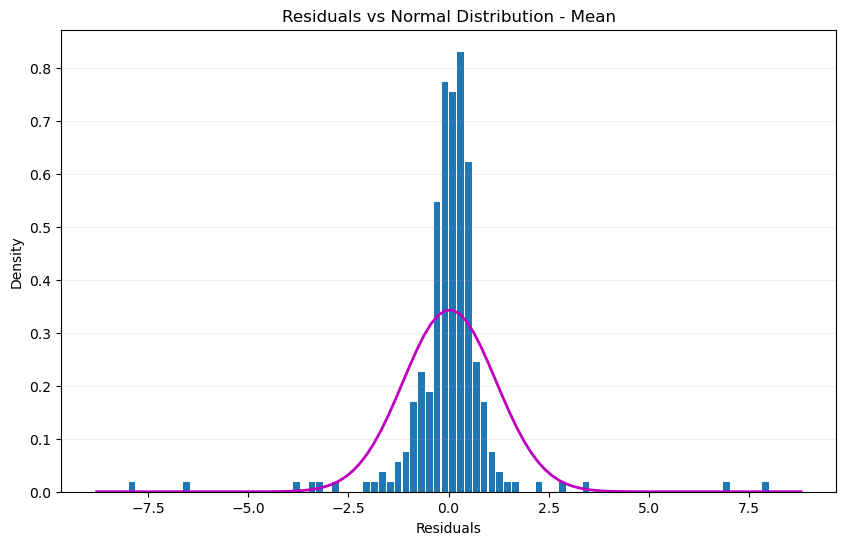

In [287]:
resid_histogram(results_AR1.resid)

The line follows what we expect to see on a normal distribution, meaning that residuals are centred around zero, suggesting the model is performing well when differentiating between the actual and predicted.

In [288]:
# Define the range of p, d, q values
p = range(0, 4)
d = range(0, 2)
q = range(0, 4)

# Generate all possible combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Load your time series data
# data = pd.read_csv('your_timeseries_data.csv')
# timeseries = data['your_timeseries_column']

# Use a sample time series data for demonstration purposes
np.random.seed(1)
timeseries = resample_df['Avg_temp']

# Find the best parameters
aic_values = []
parameters = []

for param in pdq:
    try:
        model = ARIMA(timeseries, order=param)
        result = model.fit()
        aic_values.append(result.aic)
        parameters.append(param)
    except:
        continue

# Create a DataFrame with results
results = pd.DataFrame({
    'parameters': parameters,
    'AIC': aic_values
})

# Find the parameters with the lowest AIC
best_parameters = results.loc[results['AIC'].idxmin()]

print("Best Parameters: ", best_parameters['parameters'])
print("Lowest AIC: ", best_parameters['AIC'])

Best Parameters:  (3, 1, 3)
Lowest AIC:  756.1170000064599


Identifies the best parameters to calculate the lowest AIC, which indicates how well the model fits. 

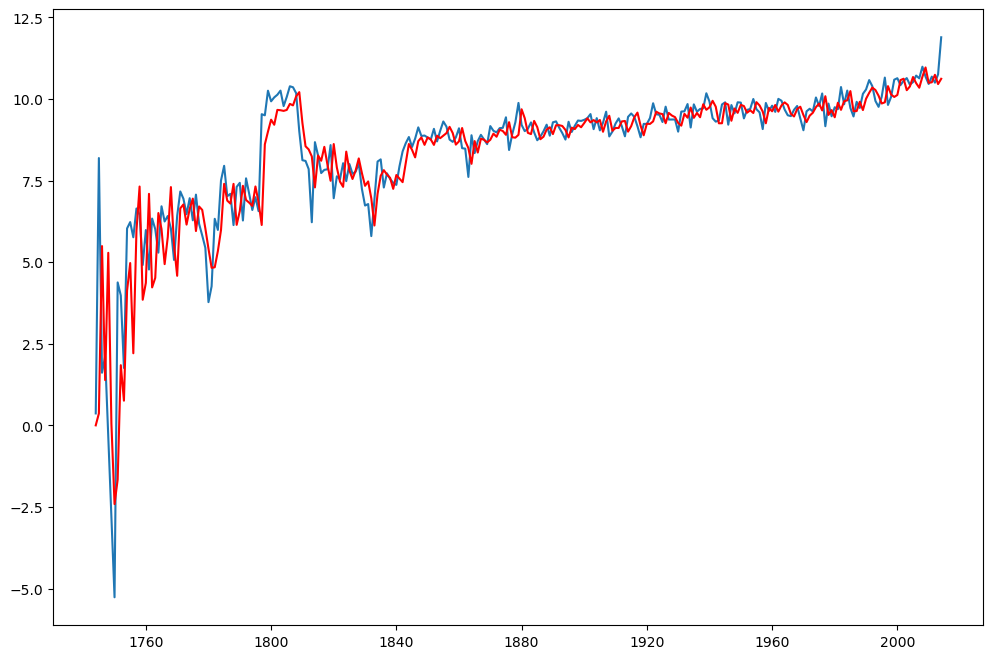

In [289]:
# Fitting another ARIMA model
model = ARIMA(resample_df, order=(3,1,3))
results_AR2 = model.fit()
plt.figure(figsize=(12, 8))
plt.plot(resample_df)
plt.plot(results_AR2.fittedvalues, color='red')
plt.show()

import warnings
warnings.filterwarnings("ignore")


The first model seems to capture the actual vs. predicted slightly better since the actual temperatures appear to be smaller in the first image compared to the second one.

In [290]:
results_AR2.fittedvalues.tail()

Date
2009-12-31    10.496609
2010-12-31    10.511584
2011-12-31    10.742071
2012-12-31    10.457504
2013-12-31    10.619695
Freq: A-DEC, dtype: float64

In [291]:
results_AR2.resid.tail()

Date
2009-12-31   -0.035071
2010-12-31    0.175078
2011-12-31   -0.241339
2012-12-31    0.298084
2013-12-31    1.272160
Freq: A-DEC, dtype: float64

In [292]:
# Use the residuals already calculated by the AR(2) model
residuals2 = results_AR2.resid
print("Residuals:")
print(residuals.tail())

Residuals:
Date
2009-12-31    0.053624
2010-12-31    0.475642
2011-12-31    0.091513
2012-12-31    0.510062
2013-12-31    1.421953
Freq: A-DEC, dtype: float64


In [293]:
# Calculate the mean of the residuals
mean_residuals = residuals2.mean()
print("Mean of Residuals:", mean_residuals)

Mean of Residuals: 0.11371021613486548


In [294]:
results_AR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Avg_temp   No. Observations:                  271
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -371.059
Date:                Sun, 07 Jul 2024   AIC                            756.117
Time:                        10:55:01   BIC                            781.306
Sample:                    12-31-1743   HQIC                           766.232
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0675      0.060     -1.125      0.261      -0.185       0.050
ar.L2         -0.5482      0.048    -11.451      0.000      -0.642      -0.454
ar.L3          0.5761      0.054     10.733      0.000       0.471       0.681
ma.L1         -0.3838      0.067     -5.727      0.000      -0.515      -0.252
ma.L2          0.4466      0.045      9.880      0.000       0.358       0.535
ma.L3         -0.7318      0.047    -15.549      0.000      -0.824      -0.640
sigma2         0.9071      0.038     24.087      0.000       0.833       0.981
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2114.10
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA (3, 1, 3) model is a better fit for the data, as indicated by its lower AIC value. However, differences between predicted and actual temperatures vary and don't follow a normal pattern. This suggests the model needs improvement.

The p-value = 0.261 suggests that the value from yesterday does not contribute to the prediction of today's temperature. But L2 and L3 values are statistically significant, meaning they do contribute to the model.

Changes between the actual and the predicted values (Heteroskedasticity Test (H)): has a low p-value, which means this inconsistency in the errors is real and not due to random chance.

Jarque-Bera Test (JB): Low p-value, high skew, and kurtosis indicate non-normal distribution, so model refining is required. 


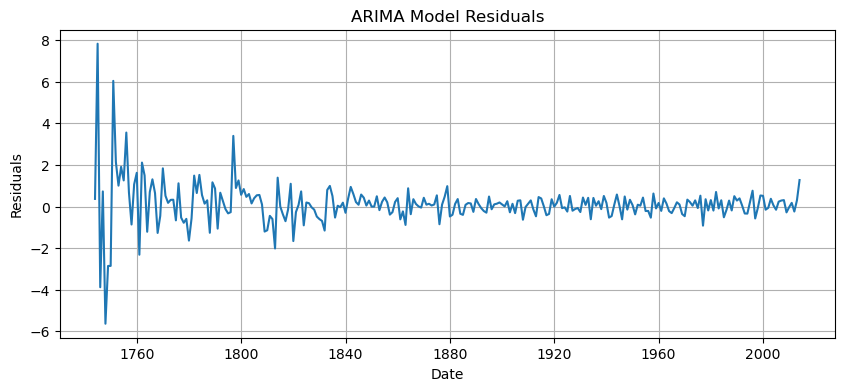

In [295]:
# Plot residuals
residuals = results_AR2.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

The residuals are concentrated close to zero, indicating that this is a well-fitted model.

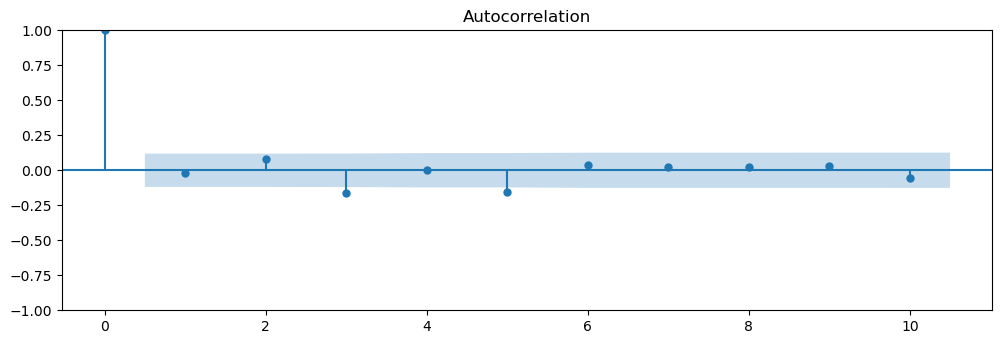

In [296]:
# ACF plot of residuals
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR2.resid, lags =10, ax=ax1)

The autocorrelations on the second model fall within the blue shaded area, reinforcing the idea that the second model fits better.

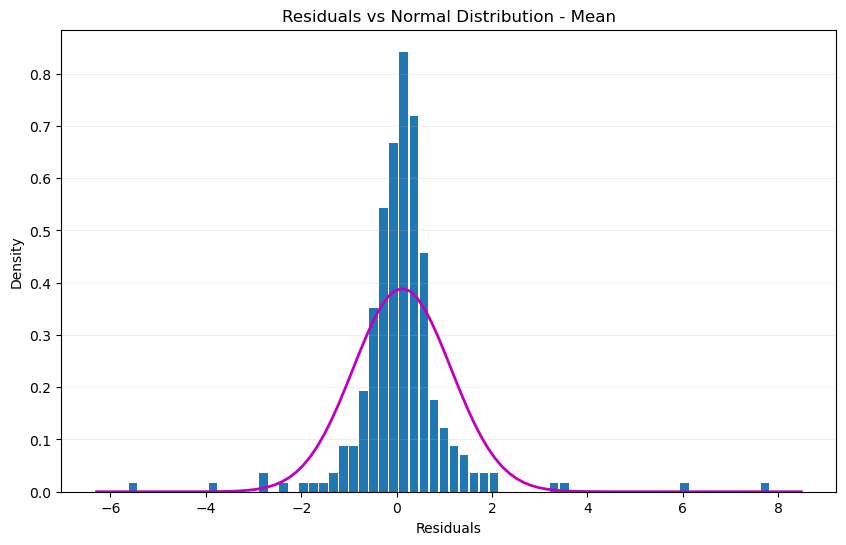

In [297]:
resid_histogram(results_AR2.resid)

 Examining the spread of a model's residuals is crucial. Ideally, these residuals should be as close as possible to a normal distribution. This indicates the model effectively balances out predictions that are too high or too low, suggesting a good fit for the data. In this case, the residuals are closer to normal compared to the initial data, which is a positive outcome.

## Data Selection and Preparation

In [298]:
# Select a specific date range
start_date = '1855-05-01'
end_date = '2013-09-01'
dfts = resample_df[start_date:end_date]

# Ensure dfts is a pandas Series and has a DatetimeIndex
if not isinstance(dfts, (pd.Series, pd.DataFrame)):
    raise ValueError("dfts should be a pandas Series or DataFrame")

if not isinstance(dfts.index, pd.DatetimeIndex):
    raise ValueError("The index of dfts should be a DatetimeIndex")

# If dfts is a DataFrame, select the 'Avg_temp' column
if isinstance(dfts, pd.DataFrame):
    dfts = dfts['Avg_temp']  # Replace 'Avg_temp' with your actual column name

## Train-Test Split

In [299]:
# Split data into train and test sets
train_size = int(len(dfts) * 0.7)
train, test = dfts[:train_size], dfts[train_size:]

print("Train set size:", len(train))
print("Test set size:", len(test))

Train set size: 110
Test set size: 48


## Model Fitting

In [300]:
# Fit the ARIMA model on training data
model = ARIMA(train, order=(3, 1, 3))
results_AR2 = model.fit()

## Predictions

In [301]:
# Make predictions on test data
predictions = results_AR2.predict(start=test.index[0], end=test.index[-1], typ='levels')

## Plotting the Results

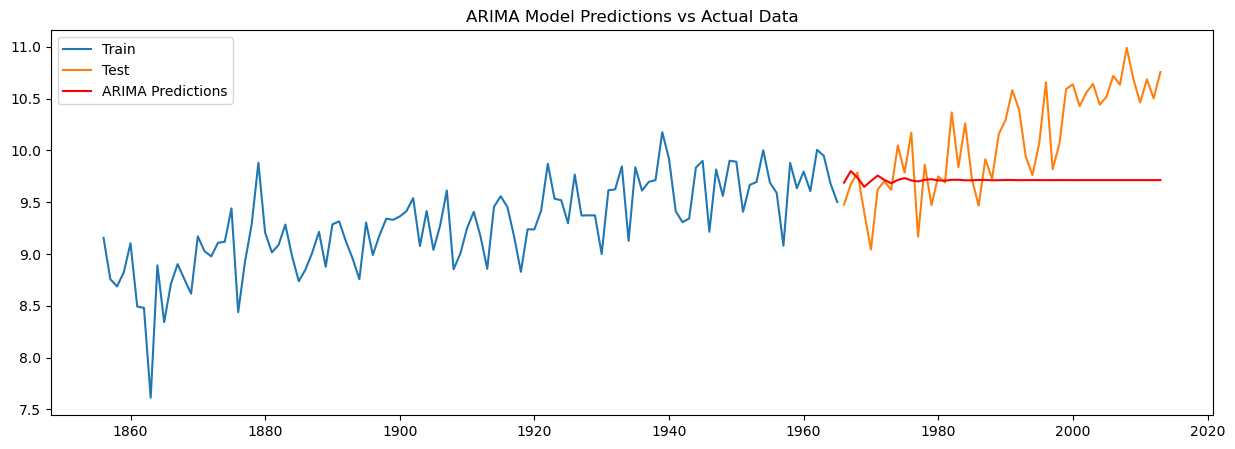

In [302]:
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predictions.index, predictions, label='ARIMA Predictions', color='red')
plt.legend(loc='best')
plt.title('ARIMA Model Predictions vs Actual Data')
plt.show()

## Error Metrics

In [303]:
from sklearn.metrics import mean_squared_error

# Calculate and print error metrics
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.3672333841758593


A small MSE (which is the gap between the ARIMA forecasts and the real values in fresh data from the test set) suggests a well-suited model.

## Forecasting

In [304]:
# Forecasting
forecast_steps = 12  # Example: Forecasting 12 steps ahead
forecast = results_AR2.forecast(steps=forecast_steps)
print(forecast)

1965-12-31    9.688340
1966-12-31    9.800378
1967-12-31    9.736164
1968-12-31    9.647870
1969-12-31    9.704268
1970-12-31    9.756747
1971-12-31    9.714483
1972-12-31    9.683168
1973-12-31    9.714407
1974-12-31    9.732465
1975-12-31    9.709871
1976-12-31    9.699878
Freq: A-DEC, Name: predicted_mean, dtype: float64


## Plotting the Forecast

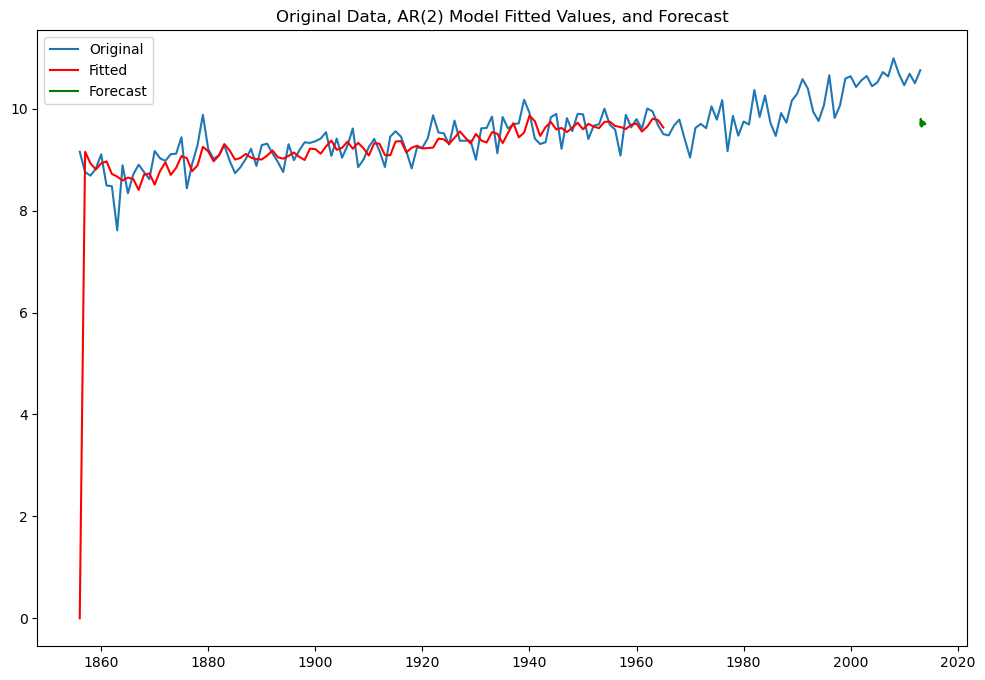

In [305]:
# Define forecast_steps and create date range for forecast
forecast_dates = pd.date_range(start=test.index[-1], periods=forecast_steps, freq='M')

# Plotting the original data, fitted values, and forecasted values
plt.figure(figsize=(12, 8))
plt.plot(dfts, label='Original')
plt.plot(results_AR2.fittedvalues, color='red', label='Fitted')
plt.plot(forecast_dates, forecast, color='green', label='Forecast')
plt.legend()
plt.title('Original Data, AR(2) Model Fitted Values, and Forecast')
plt.show()

Actual and forecast values are close, which is a good sign. 

In [314]:
average_temp_predictions = results_AR2.fittedvalues.mean()
print("Average Temperature of the Predictions:", average_temp_predictions)


Average Temperature of the Predictions: 9.171289398800676


## Model Comparison (ARIMA vs. Linear Regression)

Linear regression provides coefficients showing strength and direction of relationships between independent variables and dependent variables. Interpretability can give insights into how factors affect temperature trends.

In [306]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = resample_df.iloc[:, :1].values  # Features (independent variables)
y = resample_df.iloc[:, -1].values   # Target (dependent variable)

In [307]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
# Defining and fitting the regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [309]:
# Printing the coefficients
print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

Coefficients: [1.]
Intercept: -1.7763568394002505e-15


A coefficient of 1 and a near-zero intercept show that there is a relationship between the dates and the average temperature.

In [310]:
# Making predictions on the test data
y_test_pred = regressor.predict(X_test)


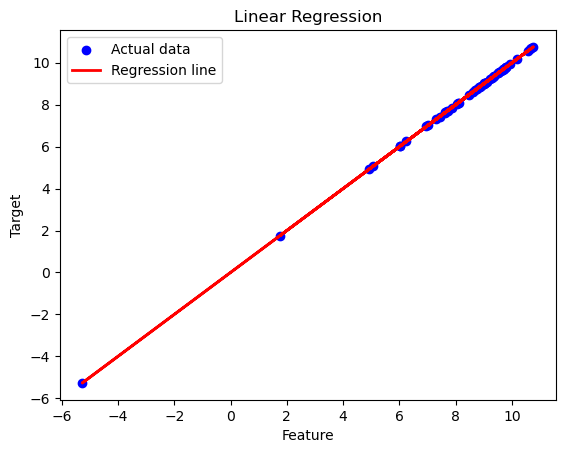

In [311]:
# Plotting the results
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_test_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.legend()
plt.show()


In [312]:
from sklearn.metrics import r2_score

# Assuming 'regressor' is your trained LinearRegression model
y_pred = regressor.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

R-squared score: 1.0


The model may not perform well on unseen data, and overfitting may be occurring, as indicated by the R-squared at 1. To ensure accurate analysis, it would be a good idea to experiment with different metrics.

## Results

- The average temperature in the data is 8.49°C. 
- The ARIMA(3,1,3) model predicts a warming trend, with the last year's average around 10.62°C, 2.13°C warmer than the current data, and an average temperature of 9.17°C. This consistency across models suggests a continuation of warming trends observed in the dataset. 
- The ARIMA(3,1,3) low MSE and AIC suggest it accurately captures trends, making its predictions reliable for climate research and policy decisions.


## Recommendations

The ARIMA(3,1,3) did a great job at forecasting temperature data. To improve our understanding, here are some next steps:

- Explore more sophisticated models and adjusting the ARIMA's parameters to see if even better forecasts are possible.
- Adding more features, like CO2 emissions, could give the models a richer picture and potentially lead to more accurate predictions.
- By including other forecasting techniques,comparisons between strengths and weaknesses are possible, ultimately choosing the best approach for this project.
- While the ARIMA(3,1,3) performed well, keeping an eye on the model's performance is crucial. As new data comes in and temperature patterns change, model refinement or even changing model might be necessary to ensure forecast precision.
